In [ ]:
from google.colab import drive
drive.mount('/gd')

Drive already mounted at /gd; to attempt to forcibly remount, call drive.mount("/gd", force_remount=True).


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
dataroot = "/gd/MyDrive/DL_project/"
# workers = 2
# batch_size = 10
# image_size = 100
# nc = 3
# nz = 100
# ngf = 100
# ndf = 100
# num_epochs = 5
# lr = 0.0002
# beta1 = 0.5
# ngpu = 0


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 100#(480, 640) #100#480#

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

(640, 480)


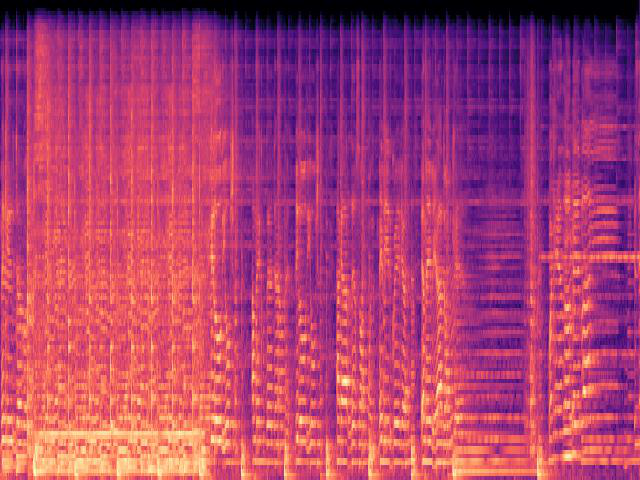

In [ ]:
# Imports PIL module 
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(f"{dataroot}/blues/rock.00000.jpg") 
print(im.size)
# This method will show image in any image viewer 
im.show() 

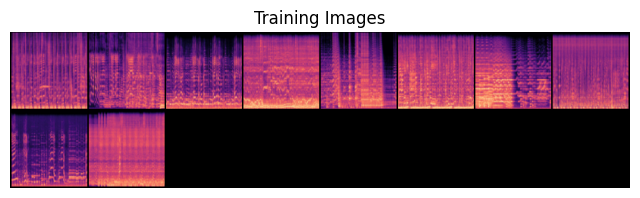

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # # input is Z, going into a convolution
            # nn.ConvTranspose2d( nz, ngf * 16, (3, 5), 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 16),
            # nn.ReLU(True),

            # nn.ConvTranspose2d( ngf * 16, ngf * 8, (5, 4), 2, 1, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),
            # # state size. ``(ngf*8) x 6 x 6``
            # nn.ConvTranspose2d(ngf * 8, ngf * 4, (5, 4), 2, 1, bias=False),
            # nn.BatchNorm2d(ngf * 4),
            # nn.ReLU(True),
            # # state size. ``(ngf*4) x 12 x 12``
            # nn.ConvTranspose2d( ngf * 4, ngf * 2, 6, 4, 1, bias=False),
            # nn.BatchNorm2d(ngf * 2),
            # nn.ReLU(True),
            # # state size. ``(ngf*2) x 25 x 25``
            # nn.ConvTranspose2d( ngf * 2, ngf, 6, 4, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # # state size. ``(ngf) x 50 x 50``
            # nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            # # state size. ``(nc) x 100 x 100``

            #########
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 6, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 6 x 6``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 12 x 12``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 25 x 25``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 50 x 50``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 100 x 100``
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # # input is ``(nc) x 640 x 480``
            # nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            # # state size. ``(ndf) x 320 x 240``
            # nn.Conv2d(ndf, ndf * 2, 6, 4, 1, bias=False),
            # nn.BatchNorm2d(ndf * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            # # state size. ``(ndf*2) x 80 x 60``
            # nn.Conv2d(ndf * 2, ndf * 4, 6, 4, 1, bias=False),
            # nn.BatchNorm2d(ndf * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            # # state size. ``(ndf*4) x 20 x 15``
            # nn.Conv2d(ndf * 4, ndf * 8, (5, 4), 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            # # state size. ``(ndf*8) x 10 x 7``
            # nn.Conv2d(ndf * 8, ndf * 16, (5, 4), 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 16),
            # nn.LeakyReLU(0.2, inplace=True),
            # # state: (ndf*16) x 5 x 3
            # nn.Conv2d(ndf * 16, 1, (3, 5), 1, 0, bias=False),
            # nn.Sigmoid()

            ###########
            # input is ``(nc) x 100 x 100``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 50 x 50``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 25 x 25``
            nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 12 x 12``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 6 x 6``
            nn.Conv2d(ndf * 8, 1, 6, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # print(real_cpu.shape)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # print(real_cpu.shape, output.shape, label.shape)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # print("FAKE: ",fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # print(output)
        # break
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        if i%2!=1:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/100]	Loss_D: 1.3328	Loss_G: 12.7525	D(x): 0.6717	D(G(z)): 0.5095 / 0.0001
[0/5][1/100]	Loss_D: 0.1886	Loss_G: 3.0585	D(x): 0.9799	D(G(z)): 0.1174 / 0.1174
[0/5][2/100]	Loss_D: 1.2621	Loss_G: 13.0103	D(x): 0.9942	D(G(z)): 0.5925 / 0.0000
[0/5][3/100]	Loss_D: 0.1102	Loss_G: 4.1641	D(x): 0.9317	D(G(z)): 0.0312 / 0.0312
[0/5][4/100]	Loss_D: 0.9251	Loss_G: 11.4632	D(x): 0.9800	D(G(z)): 0.3877 / 0.0001
[0/5][5/100]	Loss_D: 0.0979	Loss_G: 4.4797	D(x): 0.9433	D(G(z)): 0.0346 / 0.0346
[0/5][6/100]	Loss_D: 1.3347	Loss_G: 9.2908	D(x): 0.8210	D(G(z)): 0.2327 / 0.0002
[0/5][7/100]	Loss_D: 0.4579	Loss_G: 2.9259	D(x): 0.9641	D(G(z)): 0.2308 / 0.2308
[0/5][8/100]	Loss_D: 0.8367	Loss_G: 10.3130	D(x): 0.8040	D(G(z)): 0.2974 / 0.0001
[0/5][9/100]	Loss_D: 1.1557	Loss_G: 1.9788	D(x): 0.7927	D(G(z)): 0.2830 / 0.2830
[0/5][10/100]	Loss_D: 1.9119	Loss_G: 16.0247	D(x): 0.9345	D(G(z)): 0.7349 / 0.0000
[0/5][11/100]	Loss_D: 0.2542	Loss_G: 6.3445	D(x): 0.8408	D(G(z)): 0.0159 / 0.

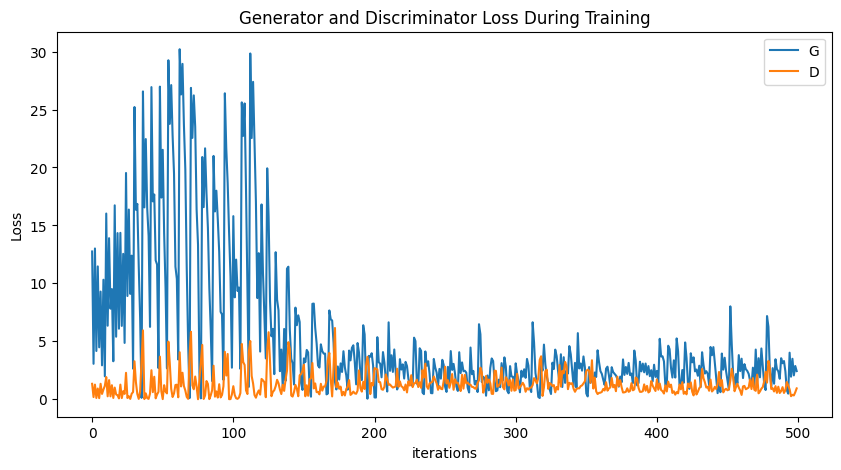

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())